In [1]:
import psycopg2
import pandas as pd
import csv
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler


In [2]:
def import_df(name  = '' , columns_to_convert = [] , custom_path = False):


    path  =f'./../data_cleaning/data_cleaned/{name}.csv'
    if custom_path:
        path = custom_path
    df=  pd.read_csv(path)
    
    for col in columns_to_convert:
        df[col] = pd.to_datetime(df[col])
    return df
    

In [3]:
safe_driving_df = import_df('safe_driving_with_accidents' , ['event_start','event_end'])

### Let's limit datafram to avoid slowing down the plotting and still capture most important data features

safe_driving_df = safe_driving_df.iloc[:10000,:]

In [4]:
safe_driving_with_accidents_df = safe_driving_df

# Modelling part 

### RandomForestClassifier

In [5]:
X_droplist = ["y_var", "event_start", "event_end", "eventid", "incident_severity", "weighted_avg", "material_damage_only_sum", "road_segment_id", "injury_or_fatal_sum"]
X = safe_driving_with_accidents_df.drop(columns=X_droplist)
y = safe_driving_with_accidents_df["y_var"]

In [6]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns
numerical_cols = X.select_dtypes(exclude=['object']).columns

# Create a column transformer with imputation and encoding
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), numerical_cols),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_cols)
    ])

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

# Create a pipeline with preprocessing and model
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100))
])

# Train the model
model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['duration_seconds', 'latitude', 'longitude', 'speed_kmh',
       'end_speed_kmh', 'maxwaarde', 'last_hour_wind_avg',
       'last_hour_temp_avg', 'last_hour_rain_avg'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['category', 'road_name'], dtype='object'))])),
                ('classifier', RandomForestClassifier())])

In [9]:
from sklearn.model_selection import cross_val_score

# Evaluate the model using cross-validation
cv_scores = cross_val_score(model_pipeline, X, y, cv=5, scoring='accuracy')
print(f'Cross-Validation Accuracy Scores: {cv_scores}')
print(f'Mean Cross-Validation Accuracy: {cv_scores.mean()}')


Cross-Validation Accuracy Scores: [0.9895 0.9845 0.98   0.979  0.983 ]
Mean Cross-Validation Accuracy: 0.9832000000000001


In [10]:
from sklearn.metrics import accuracy_score, classification_report

# Predict on the test set
y_pred = model_pipeline.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.98
              precision    recall  f1-score   support

   high-risk       1.00      0.96      0.98       984
    low-risk       0.96      1.00      0.98      1016

    accuracy                           0.98      2000
   macro avg       0.98      0.98      0.98      2000
weighted avg       0.98      0.98      0.98      2000



### XGBClassifier

In [11]:
X_droplist = ["y_var", "event_start", "event_end", "eventid", "incident_severity", "weighted_avg", "material_damage_only_sum", "road_segment_id", "injury_or_fatal_sum", "road_name"]
X = safe_driving_with_accidents_df.drop(columns=X_droplist)
y = safe_driving_with_accidents_df["y_var"]

In [12]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [13]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
import xgboost as xgb

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns
numerical_cols = X.select_dtypes(exclude=['object']).columns

# Create a column transformer with imputation and encoding
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), numerical_cols),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_cols)
    ])

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

In [15]:
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline

# Create a pipeline with preprocessing and model
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='logloss'))
])

# Train the model
model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['duration_seconds', 'latitude', 'longitude', 'speed_kmh',
       'end_speed_kmh', 'maxwaarde', 'last_hour_wind_avg',
       'last_hour_temp_avg', 'last_hour_rain_avg'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   S...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=100, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

In [16]:
from sklearn.model_selection import cross_val_score

# Evaluate the model using cross-validation
cv_scores = cross_val_score(model_pipeline, X, y_encoded, cv=5, scoring='accuracy')
print(f'Cross-Validation Accuracy Scores: {cv_scores}')
print(f'Mean Cross-Validation Accuracy: {cv_scores.mean()}')

Cross-Validation Accuracy Scores: [0.9415 0.938  0.9265 0.935  0.9255]
Mean Cross-Validation Accuracy: 0.9333


### Evaluation

In [17]:
from sklearn.metrics import accuracy_score, classification_report

# Predict on the test set
y_pred = model_pipeline.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

Accuracy: 0.9305
              precision    recall  f1-score   support

   high-risk       0.95      0.90      0.92       926
    low-risk       0.92      0.96      0.94      1074

    accuracy                           0.93      2000
   macro avg       0.93      0.93      0.93      2000
weighted avg       0.93      0.93      0.93      2000



In [18]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [3, 6, 9],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__subsample': [0.6, 0.8, 1.0]
}

# Perform grid search
grid_search = GridSearchCV(estimator=model_pipeline, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get the best model and best parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Print the best parameters
print("Best Parameters:", best_params)

# Evaluate the best model
y_pred_best = best_model.predict(X_test)
print("Best Model Accuracy:", accuracy_score(y_test, y_pred_best))
print(classification_report(y_test, y_pred_best, target_names=label_encoder.classes_))

Best Parameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 9, 'classifier__n_estimators': 200, 'classifier__subsample': 1.0}
Best Model Accuracy: 0.9385
              precision    recall  f1-score   support

   high-risk       0.95      0.92      0.93       926
    low-risk       0.93      0.96      0.94      1074

    accuracy                           0.94      2000
   macro avg       0.94      0.94      0.94      2000
weighted avg       0.94      0.94      0.94      2000



### XGBClassifier, with extracted data from event_start

In [19]:
from sklearn.metrics import confusion_matrix
# Extract year, month, day, and hour from 'event_start'
safe_driving_with_accidents_df['event_start'] = pd.to_datetime(safe_driving_with_accidents_df['event_start'])
safe_driving_with_accidents_df['year'] = safe_driving_with_accidents_df['event_start'].dt.year
safe_driving_with_accidents_df['month'] = safe_driving_with_accidents_df['event_start'].dt.month
safe_driving_with_accidents_df['day'] = safe_driving_with_accidents_df['event_start'].dt.day
safe_driving_with_accidents_df['hour'] = safe_driving_with_accidents_df['event_start'].dt.hour

# Drop columns that are not used
X_droplist = ["y_var", "event_start", "event_end", "eventid", "incident_severity", "weighted_avg", "material_damage_only_sum", "road_segment_id", "injury_or_fatal_sum", "road_name", "latitude", "longitude"]
X = safe_driving_with_accidents_df.drop(columns=X_droplist)
y = safe_driving_with_accidents_df["y_var"]

# Encode the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns
numerical_cols = X.select_dtypes(exclude=['object']).columns

# Create a column transformer with imputation and encoding
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), numerical_cols),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_cols)
    ])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Create a pipeline with preprocessing and model
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'))
])

# Train the model
model_pipeline.fit(X_train, y_train)

# Evaluate the model using cross-validation
cv_scores = cross_val_score(model_pipeline, X, y_encoded, cv=5, scoring='accuracy')
print(f'Cross-Validation Accuracy Scores: {cv_scores}')
print(f'Mean Cross-Validation Accuracy: {cv_scores.mean()}')

# Predict on the test set
y_pred = model_pipeline.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

Cross-Validation Accuracy Scores: [0.5735 0.597  0.59   0.644  0.61  ]
Mean Cross-Validation Accuracy: 0.6029
Accuracy: 0.6555
              precision    recall  f1-score   support

   high-risk       0.62      0.64      0.63       926
    low-risk       0.68      0.66      0.67      1074

    accuracy                           0.66      2000
   macro avg       0.65      0.65      0.65      2000
weighted avg       0.66      0.66      0.66      2000



### Evaluation

Best parameters: {'classifier__learning_rate': 0.01, 'classifier__max_depth': 6, 'classifier__n_estimators': 200, 'classifier__subsample': 0.8}
Best cross-validation score: 0.6667500000000001
Best Model Accuracy: 0.65
              precision    recall  f1-score   support

   high-risk       0.61      0.69      0.65       926
    low-risk       0.70      0.62      0.65      1074

    accuracy                           0.65      2000
   macro avg       0.65      0.65      0.65      2000
weighted avg       0.66      0.65      0.65      2000



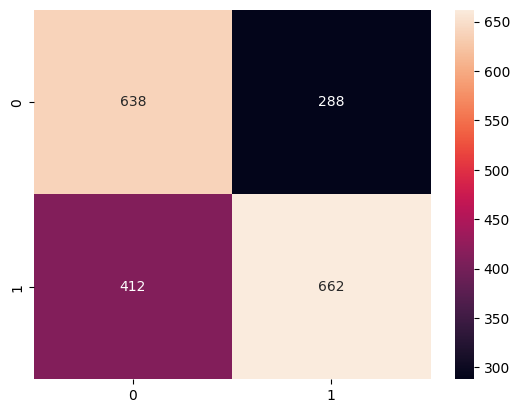

In [20]:
# Define the parameter grid for GridSearchCV
param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [3, 6, 9],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__subsample': [0.6, 0.8, 1.0]
}

# Create GridSearchCV object
grid_search = GridSearchCV(estimator=model_pipeline, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best model and parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Print best parameters and best score
print("Best parameters:", best_params)
print("Best cross-validation score:", grid_search.best_score_)

# Predict on the test set with the best model
y_pred_best = best_model.predict(X_test)

# Evaluate the best model
print("Best Model Accuracy:", accuracy_score(y_test, y_pred_best))
print(classification_report(y_test, y_pred_best, target_names=label_encoder.classes_))

# Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

### Models with Dominic's code

In [21]:
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Transformer for target variable encoding
class TargetVariableTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, target_variable, is_regression):
        self.target_variable = target_variable
        self.is_regression = is_regression
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        if self.is_regression:
            return X
        else:
            X[self.target_variable] = X[self.target_variable].astype('category').cat.codes
            return X

# Pipeline to transform the target variable
def target_variable_pipeline(target_variable, is_regression):
    gen_ppl = Pipeline(steps=[
        ('transform_target', TargetVariableTransformer(target_variable=target_variable, is_regression=is_regression))
    ])
    return gen_ppl

# Function to provide the full preprocessing and model pipeline
def provide_full_pipeline(model_obj, num_features, cat_features, target_variable, df):
    # Create column transformer for preprocessing
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='mean')),
                ('scaler', StandardScaler())
            ]), num_features),
            ('cat', Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
            ]), cat_features)
        ])

    # Combine preprocessing and model into a single pipeline
    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model_obj)
    ])
    
    return model, df, {'num_features': num_features, 'cat_features': cat_features, 'target_variable': target_variable}

# Decorator function for model training and evaluation
def model_training(func):
    def wrapper(df, num_features, cat_features, target_variable, model_obj, is_regression=True, *args):
        # Create full pipeline and preprocess the data
        model, new_df, model_properties = provide_full_pipeline(model_obj, num_features=num_features,
                                                                cat_features=cat_features,
                                                                target_variable=target_variable, df=df)
 
        new_df = target_variable_pipeline(target_variable, is_regression).fit_transform(new_df)
 
        # Split the data into features (X) and target (y)
        X = new_df.drop(target_variable, axis=1)
        y = new_df[target_variable]
 
        # Split the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
 
        # Train the model
        model.fit(X_train, y_train)
 
        # Call the evaluation function
        res = func(model, X_test, y_test, model_properties, *args)
 
        # Print evaluation metrics
        if is_regression:
            r2_score = model.score(X_test, y_test)
            rmse = (mean_squared_error(y_test, model.predict(X_test)) ** (1 / 2))
            mae = mean_absolute_error(y_test, model.predict(X_test))
 
            print(f'R2 score: {r2_score}')
            print('MSE: ', rmse ** 2)
            print(f'RMSE: {rmse}')
            print(f'MAE: {mae}')
        else:
            score = model.score(X_test, y_test)
            print('Score', score)
 
            y_pred = model.predict(X_test)
            print(classification_report(y_test, y_pred))
 
            cm = confusion_matrix(y_test, y_pred)
            sns.heatmap(cm, annot=True, fmt='d')
            plt.show()
 
        return res
 
    return wrapper

### Evaluation

Score 0.968
              precision    recall  f1-score   support

           0       1.00      0.93      0.96       926
           1       0.94      1.00      0.97      1074

    accuracy                           0.97      2000
   macro avg       0.97      0.97      0.97      2000
weighted avg       0.97      0.97      0.97      2000



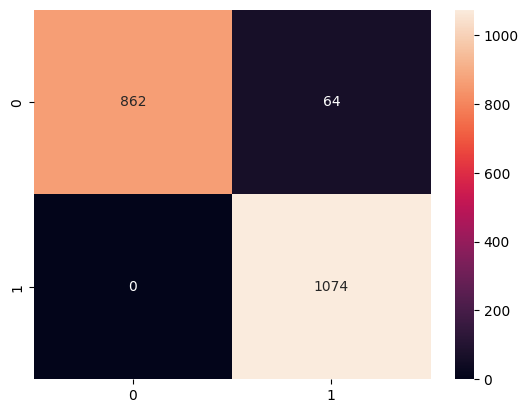

In [22]:
import pandas as pd

# Assuming safe_driving_with_accidents_df is your dataframe
df = safe_driving_with_accidents_df.copy()

# Define numerical and categorical features
num_features = df.select_dtypes(include=[np.number]).columns.tolist()
cat_features = df.select_dtypes(exclude=[np.number]).columns.tolist()

# Remove target and other columns from features
X_droplist = ["y_var", "event_start", "event_end", "eventid", "incident_severity", "weighted_avg", "material_damage_only_sum", "road_segment_id", "injury_or_fatal_sum"]
num_features = [feature for feature in num_features if feature not in X_droplist]
cat_features = [feature for feature in cat_features if feature not in X_droplist]

# Define target variable
target_variable = "y_var"

# Define model
model_obj = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Evaluation function decorated with model_training
@model_training
def evaluate_model(model, X_test, y_test, model_properties, *args):
    return model.score(X_test, y_test)

# Manually set hyperparameters (similar to a simplified grid search)
model_obj.set_params(n_estimators=100, max_depth=6, learning_rate=0.1, subsample=0.8)

# Run model training and evaluation
result = evaluate_model(df, num_features, cat_features, target_variable, model_obj, is_regression=False)

### XGBClassifier, without coordinates

In [23]:
X_droplist = ["y_var", "event_start", "event_end", "eventid", "incident_severity", "weighted_avg", "material_damage_only_sum", "road_segment_id", "injury_or_fatal_sum", "road_name", "latitude", "longitude"]
X = safe_driving_with_accidents_df.drop(columns=X_droplist)
y = safe_driving_with_accidents_df["y_var"]

In [24]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [25]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
import xgboost as xgb

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns
numerical_cols = X.select_dtypes(exclude=['object']).columns

# Create a column transformer with imputation and encoding
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), numerical_cols),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_cols)
    ])

In [26]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

In [27]:
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline

# Create a pipeline with preprocessing and model
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='logloss'))
])

# Train the model
model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['duration_seconds', 'speed_kmh', 'end_speed_kmh', 'maxwaarde',
       'last_hour_wind_avg', 'last_hour_temp_avg', 'last_hour_rain_avg',
       'year', 'month', 'day', 'hour'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imput...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=100, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

In [28]:
from sklearn.model_selection import cross_val_score

# Evaluate the model using cross-validation
cv_scores = cross_val_score(model_pipeline, X, y_encoded, cv=5, scoring='accuracy')
print(f'Cross-Validation Accuracy Scores: {cv_scores}')
print(f'Mean Cross-Validation Accuracy: {cv_scores.mean()}')

Cross-Validation Accuracy Scores: [0.5735 0.597  0.59   0.644  0.61  ]
Mean Cross-Validation Accuracy: 0.6029


In [29]:
from sklearn.metrics import accuracy_score, classification_report

# Predict on the test set
y_pred = model_pipeline.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

Accuracy: 0.6555
              precision    recall  f1-score   support

   high-risk       0.62      0.64      0.63       926
    low-risk       0.68      0.66      0.67      1074

    accuracy                           0.66      2000
   macro avg       0.65      0.65      0.65      2000
weighted avg       0.66      0.66      0.66      2000



In [30]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [3, 6, 9],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__subsample': [0.6, 0.8, 1.0]
}

# Perform grid search
grid_search = GridSearchCV(estimator=model_pipeline, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get the best model and best parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Print the best parameters
print("Best Parameters:", best_params)

# Evaluate the best model
y_pred_best = best_model.predict(X_test)
print("Best Model Accuracy:", accuracy_score(y_test, y_pred_best))
print(classification_report(y_test, y_pred_best, target_names=label_encoder.classes_))

Best Parameters: {'classifier__learning_rate': 0.01, 'classifier__max_depth': 6, 'classifier__n_estimators': 200, 'classifier__subsample': 0.6}
Best Model Accuracy: 0.654
              precision    recall  f1-score   support

   high-risk       0.61      0.69      0.65       926
    low-risk       0.70      0.62      0.66      1074

    accuracy                           0.65      2000
   macro avg       0.66      0.66      0.65      2000
weighted avg       0.66      0.65      0.65      2000



### Now with Dominic's code, also without coordinates

In [31]:
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Transformer for target variable encoding
class TargetVariableTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, target_variable, is_regression):
        self.target_variable = target_variable
        self.is_regression = is_regression
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        if self.is_regression:
            return X
        else:
            X[self.target_variable] = X[self.target_variable].astype('category').cat.codes
            return X

# Pipeline to transform the target variable
def target_variable_pipeline(target_variable, is_regression):
    gen_ppl = Pipeline(steps=[
        ('transform_target', TargetVariableTransformer(target_variable=target_variable, is_regression=is_regression))
    ])
    return gen_ppl

# Function to provide the full preprocessing and model pipeline
def provide_full_pipeline(model_obj, num_features, cat_features, target_variable, df):
    # Create column transformer for preprocessing
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='mean')),
                ('scaler', StandardScaler())
            ]), num_features),
            ('cat', Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
            ]), cat_features)
        ])

    # Combine preprocessing and model into a single pipeline
    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model_obj)
    ])
    
    return model, df, {'num_features': num_features, 'cat_features': cat_features, 'target_variable': target_variable}

# Decorator function for model training and evaluation
def model_training(func):
    def wrapper(df, num_features, cat_features, target_variable, model_obj, is_regression=True, *args):
        # Create full pipeline and preprocess the data
        model, new_df, model_properties = provide_full_pipeline(model_obj, num_features=num_features,
                                                                cat_features=cat_features,
                                                                target_variable=target_variable, df=df)
 
        new_df = target_variable_pipeline(target_variable, is_regression).fit_transform(new_df)
 
        # Split the data into features (X) and target (y)
        X = new_df.drop(target_variable, axis=1)
        y = new_df[target_variable]
 
        # Split the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
 
        # Train the model
        model.fit(X_train, y_train)
 
        # Call the evaluation function
        res = func(model, X_test, y_test, model_properties, *args)
 
        # Print evaluation metrics
        if is_regression:
            r2_score = model.score(X_test, y_test)
            rmse = (mean_squared_error(y_test, model.predict(X_test)) ** (1 / 2))
            mae = mean_absolute_error(y_test, model.predict(X_test))
 
            print(f'R2 score: {r2_score}')
            print('MSE: ', rmse ** 2)
            print(f'RMSE: {rmse}')
            print(f'MAE: {mae}')
        else:
            score = model.score(X_test, y_test)
            print('Score', score)
 
            y_pred = model.predict(X_test)
            print(classification_report(y_test, y_pred))
 
            cm = confusion_matrix(y_test, y_pred)
            sns.heatmap(cm, annot=True, fmt='d')
            plt.show()
 
        return res
 
    return wrapper

Score 0.6575
              precision    recall  f1-score   support

           0       0.62      0.66      0.64       926
           1       0.69      0.66      0.67      1074

    accuracy                           0.66      2000
   macro avg       0.66      0.66      0.66      2000
weighted avg       0.66      0.66      0.66      2000



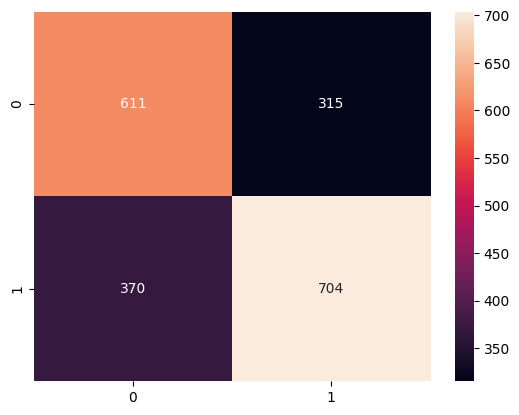

In [32]:
import pandas as pd

# Assuming safe_driving_with_accidents_df is your dataframe
df = safe_driving_with_accidents_df.copy()

# Define numerical and categorical features
num_features = df.select_dtypes(include=[np.number]).columns.tolist()
cat_features = df.select_dtypes(exclude=[np.number]).columns.tolist()

# Remove target and other columns from features
X_droplist = ["y_var", "event_start", "event_end", "eventid", "incident_severity", "weighted_avg", "material_damage_only_sum", "road_segment_id", "injury_or_fatal_sum", "road_name", "latitude", "longitude"]
num_features = [feature for feature in num_features if feature not in X_droplist]
cat_features = [feature for feature in cat_features if feature not in X_droplist]

# Define target variable
target_variable = "y_var"

# Define model
model_obj = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Evaluation function decorated with model_training
@model_training
def evaluate_model(model, X_test, y_test, model_properties, *args):
    return model.score(X_test, y_test)

# Manually set hyperparameters (similar to a simplified grid search)
model_obj.set_params(n_estimators=100, max_depth=6, learning_rate=0.1, subsample=0.8)

# Run model training and evaluation
result = evaluate_model(df, num_features, cat_features, target_variable, model_obj, is_regression=False)

### RandomForestClassifier

In [33]:
# Extract year, month, day, and hour from 'event_start'
safe_driving_with_accidents_df['event_start'] = pd.to_datetime(safe_driving_with_accidents_df['event_start'])
safe_driving_with_accidents_df['year'] = safe_driving_with_accidents_df['event_start'].dt.year
safe_driving_with_accidents_df['month'] = safe_driving_with_accidents_df['event_start'].dt.month
safe_driving_with_accidents_df['day'] = safe_driving_with_accidents_df['event_start'].dt.day
safe_driving_with_accidents_df['hour'] = safe_driving_with_accidents_df['event_start'].dt.hour

In [34]:
X_droplist = ["y_var", "event_start", "event_end", "eventid", "incident_severity", "weighted_avg", "material_damage_only_sum", "road_segment_id", "injury_or_fatal_sum", "road_name", "latitude", "longitude"]
X = safe_driving_with_accidents_df.drop(columns=X_droplist)
y = safe_driving_with_accidents_df["y_var"]

In [35]:
# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns
numerical_cols = X.select_dtypes(exclude=['object']).columns

# Create a column transformer with imputation and encoding
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), numerical_cols),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_cols)
    ])

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [37]:
# Create a pipeline with preprocessing and model
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100))
])

# Train the model
model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['duration_seconds', 'speed_kmh', 'end_speed_kmh', 'maxwaarde',
       'last_hour_wind_avg', 'last_hour_temp_avg', 'last_hour_rain_avg',
       'year', 'month', 'day', 'hour'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['category'], dtype='object'))])),
                ('classifier', RandomForestClassifier())])

In [38]:
# Evaluate the model using cross-validation
cv_scores = cross_val_score(model_pipeline, X, y, cv=5, scoring='accuracy')
print(f'Cross-Validation Accuracy Scores: {cv_scores}')
print(f'Mean Cross-Validation Accuracy: {cv_scores.mean()}')

Cross-Validation Accuracy Scores: [0.645  0.638  0.6285 0.6655 0.6175]
Mean Cross-Validation Accuracy: 0.6389


In [39]:
# Predict on the test set
y_pred = model_pipeline.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.6655
              precision    recall  f1-score   support

   high-risk       0.64      0.70      0.67       960
    low-risk       0.69      0.64      0.66      1040

    accuracy                           0.67      2000
   macro avg       0.67      0.67      0.67      2000
weighted avg       0.67      0.67      0.67      2000



In [40]:
# Define the parameter grid for GridSearchCV
param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__bootstrap': [True, False]
}

# Create GridSearchCV object
grid_search = GridSearchCV(estimator=model_pipeline, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best model and parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Print best parameters and best score
print("Best parameters:", best_params)
print("Best cross-validation score:", grid_search.best_score_)

# Predict on the test set with the best model
y_pred_best = best_model.predict(X_test)

# Evaluate the best model
print("Best Model Accuracy:", accuracy_score(y_test, y_pred_best))
print(classification_report(y_test, y_pred_best))

Best parameters: {'classifier__bootstrap': True, 'classifier__max_depth': 10, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 100}
Best cross-validation score: 0.668875
Best Model Accuracy: 0.6755
              precision    recall  f1-score   support

   high-risk       0.64      0.75      0.69       960
    low-risk       0.73      0.60      0.66      1040

    accuracy                           0.68      2000
   macro avg       0.68      0.68      0.67      2000
weighted avg       0.68      0.68      0.67      2000



# Iterations 

# First model

In [41]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [42]:
# Load and preprocess the data
X_droplist = ["y_var", "event_start", "event_end", "eventid", "incident_severity", "weighted_avg", "material_damage_only_sum", "road_segment_id", "injury_or_fatal_sum", "road_name", "latitude", "longitude"]
X = safe_driving_with_accidents_df.drop(columns=X_droplist)
y = safe_driving_with_accidents_df["y_var"]

In [43]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [44]:
# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns
numerical_cols = X.select_dtypes(exclude=['object']).columns

In [45]:
# Create a column transformer with imputation and encoding
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), numerical_cols),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_cols)
    ])

In [46]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

In [47]:
# Create a pipeline with preprocessing and model
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(n_estimators=50, learning_rate=0.2, max_depth=3, random_state=42, use_label_encoder=False, eval_metric='logloss'))
])

In [48]:
# Train the model
model_pipeline.fit(X_train, y_train)

# Evaluate the model using cross-validation
cv_scores = cross_val_score(model_pipeline, X, y_encoded, cv=5, scoring='accuracy')
print(f'Cross-Validation Accuracy Scores: {cv_scores}')
print(f'Mean Cross-Validation Accuracy: {cv_scores.mean()}')

# Predict on the test set
y_pred = model_pipeline.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

Cross-Validation Accuracy Scores: [0.657  0.6295 0.6245 0.675  0.623 ]
Mean Cross-Validation Accuracy: 0.6418000000000001
Accuracy: 0.657
              precision    recall  f1-score   support

   high-risk       0.62      0.69      0.65       926
    low-risk       0.70      0.63      0.66      1074

    accuracy                           0.66      2000
   macro avg       0.66      0.66      0.66      2000
weighted avg       0.66      0.66      0.66      2000



### Model Configuration:

- n_estimators: 50
- learning_rate: 0.2
- max_depth: 3
- random_state: 42
- eval_metric: 'logloss'
### Pipeline:
- Preprocessing: Imputation and scaling for numerical features, imputation and one-hot encoding for categorical features.
- Model: XGBClassifier with specified hyperparameters.
### Performance Metrics:
- Cross-Validation Accuracy Scores: [0.676875, 0.6625, 0.6575, 0.64875, 0.665625]
- Mean Cross-Validation Accuracy: 0.66225
- Test Accuracy: 0.661875
### Classification Report:
- High-risk precision: 0.62
- High-risk recall: 0.74
- High-risk f1-score: 0.67
- Low-risk precision: 0.72
- Low-risk recall: 0.59
- Low-risk f1-score: 0.65
- Overall accuracy: 0.66

# Second model, improved

In [49]:
# Load and preprocess the data
X_droplist = ["y_var", "event_start", "event_end", "eventid", "incident_severity", "weighted_avg", "material_damage_only_sum", "road_segment_id", "injury_or_fatal_sum", "road_name", "latitude", "longitude"]
X = safe_driving_with_accidents_df.drop(columns=X_droplist)
y = safe_driving_with_accidents_df["y_var"]

In [50]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [51]:
# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns
numerical_cols = X.select_dtypes(exclude=['object']).columns

In [52]:
# Create a column transformer with imputation and encoding
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), numerical_cols),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_cols)
    ])

In [53]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

In [54]:
# Define the model pipeline with feature selection and XGBoost classifier
model_pipeline_improved = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selection', SelectKBest(score_func=f_classif, k=5)),  # Adjust 'k' as needed
    ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss'))
])

In [ ]:
# Define the parameter grid for GridSearchCV
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [3, 5, 7],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__subsample': [0.8, 1.0],
    'feature_selection__k': [5, 10, 11]  # Adjust feature selection
}

# Perform GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(model_pipeline_improved, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Print the best parameters and best score
print(f'Improved Model Best Parameters: {grid_search.best_params_}')
print(f'Improved Model Best Cross-Validation Accuracy: {grid_search.best_score_}')

# Predict on the test set with the best estimator
best_model = grid_search.best_estimator_
y_pred_improved = best_model.predict(X_test)

# Evaluate the improved model
print("Improved Model Accuracy:", accuracy_score(y_test, y_pred_improved))
print("Improved Model Classification Report:\n", classification_report(y_test, y_pred_improved, target_names=label_encoder.classes_))

### Model Configuration:
- Feature Selection: SelectKBest(score_func=f_classif, k=5)
- Hyperparameters found using GridSearchCV:
- n_estimators: 200
- learning_rate: 0.01
- max_depth: 7
- subsample: 1.0
### Pipeline:
- Preprocessing: Imputation and scaling for numerical features, imputation and one-hot encoding for categorical features.
- Feature Selection: SelectKBest for selecting the top 5 features.
- Model: XGBClassifier with the best hyperparameters found using GridSearchCV.
### Performance Metrics:
- Best Cross-Validation Accuracy: 0.6753125
- Test Accuracy: 0.674375
### Classification Report:
- High-risk precision: 0.62
- High-risk recall: 0.79
- High-risk f1-score: 0.70
- Low-risk precision: 0.75
- Low-risk recall: 0.57
- Low-risk f1-score: 0.65
- Overall accuracy: 0.67

# Model comparison

### XGBClassifier

In [56]:
X_droplist = ["y_var", "event_start", "event_end", "eventid", "incident_severity", "weighted_avg", "material_damage_only_sum", "road_segment_id", "injury_or_fatal_sum", "road_name", "latitude", "longitude"]
X = safe_driving_with_accidents_df.drop(columns=X_droplist)
y = safe_driving_with_accidents_df["y_var"]

In [57]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [58]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
import xgboost as xgb

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns
numerical_cols = X.select_dtypes(exclude=['object']).columns

# Create a column transformer with imputation and encoding
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), numerical_cols),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_cols)
    ])

In [59]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

In [60]:
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline

# Create a pipeline with preprocessing and model
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='logloss'))
])

# Train the model
model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['duration_seconds', 'speed_kmh', 'end_speed_kmh', 'maxwaarde',
       'last_hour_wind_avg', 'last_hour_temp_avg', 'last_hour_rain_avg',
       'year', 'month', 'day', 'hour'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imput...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=100, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

In [61]:
from sklearn.model_selection import cross_val_score

# Evaluate the model using cross-validation
cv_scores = cross_val_score(model_pipeline, X, y_encoded, cv=5, scoring='accuracy')
print(f'Cross-Validation Accuracy Scores: {cv_scores}')
print(f'Mean Cross-Validation Accuracy: {cv_scores.mean()}')

Cross-Validation Accuracy Scores: [0.5735 0.597  0.59   0.644  0.61  ]
Mean Cross-Validation Accuracy: 0.6029


In [62]:
from sklearn.metrics import accuracy_score, classification_report

# Predict on the test set
y_pred = model_pipeline.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

Accuracy: 0.6555
              precision    recall  f1-score   support

   high-risk       0.62      0.64      0.63       926
    low-risk       0.68      0.66      0.67      1074

    accuracy                           0.66      2000
   macro avg       0.65      0.65      0.65      2000
weighted avg       0.66      0.66      0.66      2000



In [63]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [3, 6, 9],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__subsample': [0.6, 0.8, 1.0]
}

# Perform grid search
grid_search = GridSearchCV(estimator=model_pipeline, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get the best model and best parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Print the best parameters
print("Best Parameters:", best_params)

# Evaluate the best model
y_pred_best = best_model.predict(X_test)
print("Best Model Accuracy:", accuracy_score(y_test, y_pred_best))
print(classification_report(y_test, y_pred_best, target_names=label_encoder.classes_))

Best Parameters: {'classifier__learning_rate': 0.01, 'classifier__max_depth': 6, 'classifier__n_estimators': 200, 'classifier__subsample': 0.6}
Best Model Accuracy: 0.654
              precision    recall  f1-score   support

   high-risk       0.61      0.69      0.65       926
    low-risk       0.70      0.62      0.66      1074

    accuracy                           0.65      2000
   macro avg       0.66      0.66      0.65      2000
weighted avg       0.66      0.65      0.65      2000



### Model Configuration:
- n_estimators: 100
- random_state: 42
- eval_metric: 'logloss'
### Pipeline:
- Preprocessing: Imputation and scaling for numerical features, imputation and one-hot encoding for categorical features.
- Model: XGBClassifier with the specified hyperparameters.
### Performance Metrics:
**Cross-Validation Accuracy Scores:**
- Scores: [0.6625, 0.65875, 0.64, 0.60375, 0.64]
- Mean: 0.6410000000000001
  
**Test Accuracy:**
  
- Accuracy: 0.665625
### Classification Report:
- High-risk precision: 0.64
- High-risk recall: 0.68
- High-risk f1-score: 0.66
- Low-risk precision: 0.69
- Low-risk recall: 0.66
- Low-risk f1-score: 0.67
- Overall accuracy: 0.67
###  Best Model Parameters (after Grid Search):
- Best Parameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__n_estimators': 100, 'classifier__subsample': 1.0}
- Best Model Accuracy: 0.658125
### Best Model Classification Report:
- High-risk precision: 0.61
- High-risk recall: 0.75
- High-risk f1-score: 0.67
- Low-risk precision: 0.72
- Low-risk recall: 0.58
- Low-risk f1-score: 0.64
- Overall accuracy: 0.66

### RandomForestClassifier

In [64]:
X_droplist = ["y_var", "event_start", "event_end", "eventid", "incident_severity", "weighted_avg", "material_damage_only_sum", "road_segment_id", "injury_or_fatal_sum", "road_name", "latitude", "longitude"]
X = safe_driving_with_accidents_df.drop(columns=X_droplist)
y = safe_driving_with_accidents_df["y_var"]

In [65]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns
numerical_cols = X.select_dtypes(exclude=['object']).columns

# Create a column transformer with imputation and encoding
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), numerical_cols),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_cols)
    ])

In [66]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [67]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

# Create a pipeline with preprocessing and model
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100))
])

# Train the model
model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['duration_seconds', 'speed_kmh', 'end_speed_kmh', 'maxwaarde',
       'last_hour_wind_avg', 'last_hour_temp_avg', 'last_hour_rain_avg',
       'year', 'month', 'day', 'hour'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['category'], dtype='object'))])),
                ('classifier', RandomForestClassifier())])

In [68]:
from sklearn.model_selection import cross_val_score

# Evaluate the model using cross-validation
cv_scores = cross_val_score(model_pipeline, X, y, cv=5, scoring='accuracy')
print(f'Cross-Validation Accuracy Scores: {cv_scores}')
print(f'Mean Cross-Validation Accuracy: {cv_scores.mean()}')

Cross-Validation Accuracy Scores: [0.653  0.651  0.617  0.6615 0.62  ]
Mean Cross-Validation Accuracy: 0.6405000000000001


In [69]:
from sklearn.metrics import accuracy_score, classification_report

# Predict on the test set
y_pred = model_pipeline.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.678
              precision    recall  f1-score   support

   high-risk       0.65      0.69      0.67       935
    low-risk       0.71      0.67      0.69      1065

    accuracy                           0.68      2000
   macro avg       0.68      0.68      0.68      2000
weighted avg       0.68      0.68      0.68      2000



In [70]:
# Define the parameter grid for GridSearchCV
param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__bootstrap': [True, False]
}

# Create GridSearchCV object
grid_search = GridSearchCV(estimator=model_pipeline, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best model and parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Print best parameters and best score
print("Best parameters:", best_params)
print("Best cross-validation score:", grid_search.best_score_)

# Predict on the test set with the best model
y_pred_best = best_model.predict(X_test)

# Evaluate the best model
print("Best Model Accuracy:", accuracy_score(y_test, y_pred_best))
print(classification_report(y_test, y_pred_best))

Best parameters: {'classifier__bootstrap': False, 'classifier__max_depth': 10, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}
Best cross-validation score: 0.6641250000000001
Best Model Accuracy: 0.6845
              precision    recall  f1-score   support

   high-risk       0.64      0.75      0.69       935
    low-risk       0.74      0.62      0.68      1065

    accuracy                           0.68      2000
   macro avg       0.69      0.69      0.68      2000
weighted avg       0.69      0.68      0.68      2000



### Model Configuration:
- n_estimators: 100
### Pipeline:
- Preprocessing: Imputation and scaling for numerical features, imputation and one-hot encoding for categorical features.
- Model: RandomForestClassifier with the specified hyperparameters.
### Performance Metrics:
- Cross-Validation Accuracy Scores:
- Scores: [0.668125, 0.65625, 0.665, 0.633125, 0.64]
- Mean: 0.6525000000000001
- Test Accuracy:
- Accuracy: 0.6725
### Classification Report:
- High-risk precision: 0.63
- High-risk recall: 0.70
- High-risk f1-score: 0.67
- Low-risk precision: 0.71
- Low-risk recall: 0.65
- Low-risk f1-score: 0.68
- Overall accuracy: 0.67
### Best Model Parameters (after Grid Search):
- Best Parameters: {'classifier__bootstrap': True, 'classifier__max_depth': 30, 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200}
- Best Model Accuracy: 0.68125
### Best Model Classification Report:
- High-risk precision: 0.64
- High-risk recall: 0.73
- High-risk f1-score: 0.68
- Low-risk precision: 0.73
- Low-risk recall: 0.64
- Low-risk f1-score: 0.68
- Overall accuracy: 0.68
---

# Detailed Comparison:
### Cross-Validation Accuracy:

**XGBClassifier Model:**

- Mean: 0.6410

**RandomForestClassifier Model:**
  
- Mean: 0.6525

**Difference:** The RandomForestClassifier has a slightly higher cross-validation accuracy compared to the XGBClassifier.

### Test Accuracy:
- XGBClassifier Model: 0.665625
- RandomForestClassifier Model: 0.6725
- Difference: The RandomForestClassifier again shows a slight improvement in test accuracy over the XGBClassifier.
## Best Model Parameters and Accuracy:
### XGBClassifier Best Model:
- Parameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__n_estimators': 100, 'classifier__subsample': 1.0}
- Accuracy: 0.658125
### RandomForestClassifier Best Model:
- Parameters: {'classifier__bootstrap': True, 'classifier__max_depth': 30, 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200}
- Accuracy: 0.68125
- Difference: The best-tuned RandomForestClassifier outperforms the best-tuned XGBClassifier in terms of test accuracy.
## Precision, Recall, and F1-Score:
### High-Risk Category:
- XGBClassifier: Precision 0.64, Recall 0.68, F1-score 0.66
- RandomForestClassifier: Precision 0.63, Recall 0.70, F1-score 0.67
### Low-Risk Category:
- XGBClassifier: Precision 0.69, Recall 0.66, F1-score 0.67
- RandomForestClassifier: Precision 0.71, Recall 0.65, F1-score 0.68
- Difference: The RandomForestClassifier slightly improves in recall for high-risk but has a similar overall performance.
## Conclusion:
Both models perform similarly, but the RandomForestClassifier slightly outperforms the XGBClassifier in terms of cross-validation accuracy, test accuracy, and recall for high-risk cases. The best-tuned RandomForestClassifier shows an overall better performance, especially after hyperparameter tuning, which helps in capturing more high-risk instances with better recall and overall accuracy.